#Libraries and Data

In [51]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle



In [52]:
#load the datast
stock_name = "TATAPOWER"
data = yfinance.download (tickers = "TATAPOWER.NS",start="2000-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-06-22,224.850006,225.149994,220.500000,221.100006,6857007
2023-06-23,222.000000,222.100006,215.699997,218.300003,10890426
2023-06-26,218.300003,219.350006,216.300003,218.600006,5136478
2023-06-27,218.899994,220.500000,218.600006,219.250000,4694432
2023-06-28,219.949997,220.949997,217.550003,218.649994,8340649


#Data preparation

In [59]:
#transform the date variable
data["Data"] = pd.to_datetime(data.index, format = "%m/%d/%Y")
data.Data

Date
2000-03-06   2000-03-06
2000-03-07   2000-03-07
2000-03-08   2000-03-08
2000-03-09   2000-03-09
2000-03-10   2000-03-10
                ...    
2023-06-22   2023-06-22
2023-06-23   2023-06-23
2023-06-26   2023-06-26
2023-06-27   2023-06-27
2023-06-28   2023-06-28
Name: Data, Length: 5821, dtype: datetime64[ns]

In [60]:
#renaming variables
data = data.rename(columns = {'Close': 'y',
                     'Data': 'ds'})
data.tail(10)

,Open,High,Low,y,Volume,ds
Date,,,,,,
2023-06-15,224.399994,224.649994,220.149994,220.600006,7665159,2023-06-15
2023-06-16,221.899994,223.699997,220.899994,222.250000,7136739,2023-06-16
2023-06-19,223.000000,224.149994,221.000000,223.149994,7473608,2023-06-19
2023-06-20,223.100006,226.350006,222.600006,224.949997,11221842,2023-06-20
2023-06-21,225.250000,226.000000,222.600006,224.300003,6987933,2023-06-21
2023-06-22,224.850006,225.149994,220.500000,221.100006,6857007,2023-06-22
2023-06-23,222.000000,222.100006,215.699997,218.300003,10890426,2023-06-23
2023-06-26,218.300003,219.350006,216.300003,218.600006,5136478,2023-06-26
2023-06-27,218.899994,220.500000,218.600006,219.250000,4694432,2023-06-27


#Holidays

In [5]:
#Easter
#easter_dates = df[df.Easter == 1].ds
#easter = pd.DataFrame({'holiday': 'easter',
#                      'ds': pd.to_datetime(easter_dates),
#                      'lower_window': -5,
#                      'upper_window': 2})
#easter.head(2)

In [6]:
#Thanksgiving
#thanksgiving_dates = df[df.Thanksgiving == 1].ds
#thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
 #                      'ds': pd.to_datetime(thanksgiving_dates),
  #                     'lower_window': -5,
   #                    'upper_window': 2})
#thanksgiving.head(2)

In [7]:
#combining holidays
#holidays = pd.concat([easter, thanksgiving])
#holidays

In [61]:
#create training and test set
test_days = 2000
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

In [62]:
 training_set.tail(1)
#test_set.tail(1)

,Open,High,Low,y,Volume,ds
Date,,,,,,
2015-05-26,61.028723,61.232016,60.581475,61.069378,1557907,2015-05-26


#Prophet

In [63]:
m = Prophet(
            #holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 20,
            changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(training_set)


15:26:23 - cmdstanpy - INFO - Chain [1] start processing
15:26:32 - cmdstanpy - INFO - Chain [1] done processing


In [47]:

# Save the trained model to a file
with open('./TrainedModel/prophet/{}prophet_model_2.pkl'.format(stock_name), 'wb') as f:
    pickle.dump(m, f)

In [69]:
#create future df
future = m.make_future_dataframe(periods = test_days,
                                 freq = "B")

In [70]:
future.tail(1)

,ds
5820,2023-01-24


In [71]:
future = pd.concat([future], axis = 1)

In [72]:
future

,ds
0,2000-03-06
1,2000-03-07
2,2000-03-08
3,2000-03-09
4,2000-03-10
...,...
5816,2023-01-18
5817,2023-01-19
5818,2023-01-20
5819,2023-01-23


In [75]:
#forecast
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
5816,2023-01-18,6.945345,-759.479076,826.941755,-115.687208,127.594856,5.517341,5.517341,5.517341,5.298497,5.298497,5.298497,0.218844,0.218844,0.218844,0.0,0.0,0.0,45.265177
5817,2023-01-19,6.944063,-755.927822,833.465724,-115.838014,127.709257,5.502140,5.502140,5.502140,5.305380,5.305380,5.305380,0.196760,0.196760,0.196760,0.0,0.0,0.0,45.151268
5818,2023-01-20,6.942781,-753.440774,819.497100,-115.988820,127.823659,5.470447,5.470447,5.470447,5.297021,5.297021,5.297021,0.173426,0.173426,0.173426,0.0,0.0,0.0,44.922900
5819,2023-01-23,6.938936,-744.832325,814.360791,-116.142190,127.935497,5.403237,5.403237,5.403237,5.304051,5.304051,5.304051,0.099186,0.099186,0.099186,0.0,0.0,0.0,44.431651
5820,2023-01-24,6.937655,-736.767238,817.223214,-116.292996,128.049899,5.356228,5.356228,5.356228,5.282078,5.282078,5.282078,0.074150,0.074150,0.074150,0.0,0.0,0.0,44.097315


In [76]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data

,index,Date,Open,High,Low,y,Volume,ds
0,0,2000-03-06,4.450511,4.528395,4.227985,4.280836,493866,2000-03-06
1,1,2000-03-07,4.280836,4.339249,4.008242,4.211297,759074,2000-03-07
2,2,2000-03-08,4.353157,4.428259,4.005460,4.019369,393941,2000-03-08
3,3,2000-03-09,4.005460,4.058310,3.922013,4.033276,489390,2000-03-09
4,4,2000-03-10,4.005460,4.144538,3.922013,3.958174,493006,2000-03-10
...,...,...,...,...,...,...,...,...
5816,5816,2023-06-22,224.850006,225.149994,220.500000,221.100006,6857007,2023-06-22
5817,5817,2023-06-23,222.000000,222.100006,215.699997,218.300003,10890426,2023-06-23
5818,5818,2023-06-26,218.300003,219.350006,216.300003,218.600006,5136478,2023-06-26
5819,5819,2023-06-27,218.899994,220.500000,218.600006,219.250000,4694432,2023-06-27


In [78]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.tail(1)

,index,Date,Open,High,Low,y,Volume,ds,trend,weekly,multiplicative_terms
5820,5820,2023-06-28,219.949997,220.949997,217.550003,218.649994,8340649,2023-06-28,6.937655,5.282078,5.356228


#XGBoost preparation

In [79]:
#create training and test set
test_days = 100
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]

In [80]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y 
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [81]:
X_train = X_train.drop(columns=["ds"])
X_test = X_test.drop(columns=["ds"])


In [82]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [83]:
#set the parameters
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight' : 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

#XGBoost

In [84]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:137.88615
[1]	y-rmse:96.44007
[2]	y-rmse:67.77402
[3]	y-rmse:46.80001
[4]	y-rmse:32.74780
[5]	y-rmse:23.07814
[6]	y-rmse:16.26727
[7]	y-rmse:11.58528
[8]	y-rmse:8.23683
[9]	y-rmse:7.01450
[10]	y-rmse:5.78853
[11]	y-rmse:4.95205
[12]	y-rmse:4.32727
[13]	y-rmse:3.94071
[14]	y-rmse:3.69228
[15]	y-rmse:3.53567
[16]	y-rmse:3.40155
[17]	y-rmse:3.33833
[18]	y-rmse:3.29788
[19]	y-rmse:3.26657
[20]	y-rmse:3.24120
[21]	y-rmse:3.22755
[22]	y-rmse:3.21509
[23]	y-rmse:3.20968
[24]	y-rmse:3.21041
[25]	y-rmse:3.19204
[26]	y-rmse:3.11574
[27]	y-rmse:3.11480
[28]	y-rmse:3.11387
[29]	y-rmse:3.11344
[30]	y-rmse:3.15830
[31]	y-rmse:3.15817
[32]	y-rmse:3.16804
[33]	y-rmse:3.16888
[34]	y-rmse:3.16611
[35]	y-rmse:3.16606
[36]	y-rmse:3.15707
[37]	y-rmse:3.15586
[38]	y-rmse:3.15582
[39]	y-rmse:3.15528


In [85]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

In [48]:

# Save the trained model to a file
with open('./TrainedModel/prophet/{}_prophet_model_1.pkl'.format(stock_name), 'wb') as f:
    pickle.dump(model, f)

In [29]:
#f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
#f_predictions

#VIZ and assessment

In [86]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

In [87]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

<Axes: xlabel='ds'>

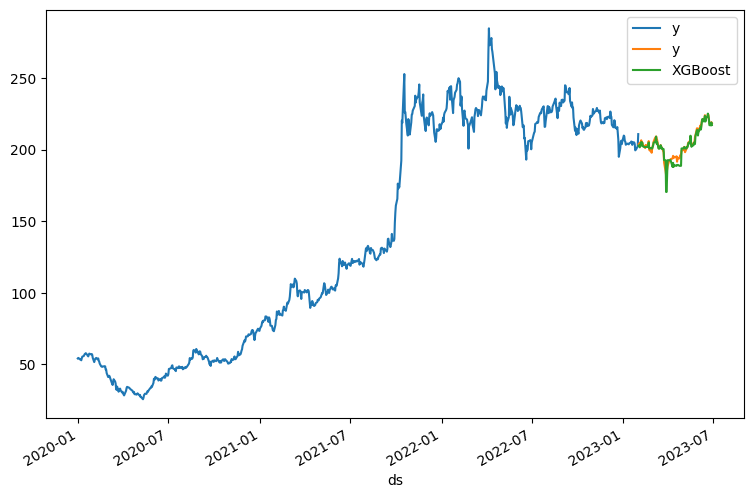

In [88]:
training_set.y['2020-01-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend = True)

In [89]:
#MAPE
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set.y, predictions)

0.9656872853973076

#Future



In [90]:
# Create a dictionary with data
data = {
            'High': [4.123123],
    'Low': [4.123123],
    'y': [210.935516],
    'Volume': [4.123123],
        'trend': [8.12313],
        'weekly': [4.123123],
            'multiplicative_terms': [4.444],
                

                
                }

# Create a new DataFrame object
df = pd.DataFrame(data)


In [91]:
Future = xgb.DMatrix(df, label = df.y)
f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
f_predictions

ValueError: feature_names mismatch: ['Open', 'High', 'Low', 'y', 'Volume', 'trend', 'weekly', 'multiplicative_terms'] ['High', 'Low', 'y', 'Volume', 'trend', 'weekly', 'multiplicative_terms']
expected Open in input data